# Chat Duell
___

In [1]:
from __future__ import unicode_literals
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sys
import datetime
import common.chat
import common.live

In [2]:
#config
reload(sys)
sys.setdefaultencoding('utf-8')
matplotlib.style.use('ggplot')
%matplotlib inline

#constants
CHAT_DATA_DIRECTORY = '/home/marcel/Development/rbtvdata/chat'
LIVE_DATA_DIRECTORY = '/home/marcel/Development/rbtvdata/live'

## Chat Daten
___

In [3]:
#load chat data
chat = common.chat.load(CHAT_DATA_DIRECTORY)

#create additional columns
chat['date'] = chat.index.date
chat['time'] = chat.index.time
chat['weekday'] = chat.index.dayofweek

In [4]:
chat.head()

,username,message,date,time,weekday
datetime,,,,,
2015-08-05 02:00:09,tadloss,!sendeplan,2015-08-05,02:00:09,2
2015-08-05 02:00:09,moobot,Angaben zum aktuellen Programm findet Ihr: Auf...,2015-08-05,02:00:09,2
2015-08-05 02:00:10,dersendeplan,@tadloss (01:00) Blue Estate >> (02:30) Darkes...,2015-08-05,02:00:10,2
2015-08-05 02:00:17,dedalos_stormbring,"@Gunvolf, Brav. Kappa",2015-08-05,02:00:17,2
2015-08-05 02:00:18,unclesreefermadness,ist da nicht schmatzen gäng und ein kompliment,2015-08-05,02:00:18,2


In [5]:
chat.tail()

,username,message,date,time,weekday
datetime,,,,,
2016-09-25 20:00:40,Roebyte,Andi Möller Rip 😞,2016-09-25,20:00:40,6
2016-09-25 20:00:41,Pablo Corleone,trant,2016-09-25,20:00:41,6
2016-09-25 20:00:42,+Hasenpriester,Is das Berlin beim Alex um de Ecke wo er da si...,2016-09-25,20:00:42,6
2016-09-25 20:00:45,DannyTheKidd,jaja hihi xD,2016-09-25,20:00:45,6
2016-09-25 20:00:48,+b34v13s,Aber Andy Möller ist doch gar nicht tot....,2016-09-25,20:00:48,6


In [6]:
#filter chat data by time
start = datetime.time(20, 15, 0)
end = datetime.time(22, 0, 0)
chatFiltered = chat.between_time(start, end)

#filter chat data by messages containing `!cd`
chatFiltered = chatFiltered[chatFiltered['message'].str.contains('!cd')]

#filter chat data by weekday
chatFiltered = chatFiltered[chatFiltered['weekday'] == 1]

#group chat data by date
chatGrouped = chatFiltered.groupby('date')

#filter groups by count threshold
chatGrouped = chatGrouped.filter(lambda group: len(group) > 2000)

#group chat data by date
chatGrouped = chatGrouped.groupby('date')

#count unique users
chatParticipants = chatGrouped.agg({'username': pd.Series.nunique})
chatParticipants.columns = ['participants']

## Live Daten
___

In [7]:
#load live data
live = common.live.load(LIVE_DATA_DIRECTORY)

In [8]:
live.head()

,viewers
datetime,
2015-01-15 18:37:00,757.000000
2015-01-15 18:38:00,2379.166667
2015-01-15 18:39:00,10490.000000
2015-01-15 18:40:00,13232.000000
2015-01-15 18:41:00,13232.000000


In [9]:
live.tail()

,viewers
datetime,
2016-09-25 19:56:00,2910.0
2016-09-25 19:57:00,2957.0
2016-09-25 19:58:00,3000.0
2016-09-25 19:59:00,3037.0
2016-09-25 20:00:00,3068.0


In [10]:
#prepare live viewer data
liveMeanTmp = []
for date, count in chatGrouped.size().iteritems():
    start = datetime.datetime.combine(date, datetime.time(20, 15, 0))
    end = datetime.datetime.combine(date, datetime.time(22, 0, 0))
    viewers = live.loc[start : end]['viewers']
    liveMeanTmp.append((date, int(viewers.mean())))

#live mean viewers dataframe
liveMean = pd.DataFrame(liveMeanTmp, columns=['date', 'viewers'])

#index
liveMean = liveMean.set_index(liveMean['date'])
liveMean.drop('date', axis=1, inplace=True)

liveMean

,viewers
date,
2015-12-01,19536
2015-12-08,20222
2015-12-15,14152
2015-12-22,15197
2016-01-12,18277
2016-01-19,17225
2016-02-02,15669
2016-02-09,36155
2016-02-16,16123


In [11]:
#join data
joinedData = chatParticipants.join(liveMean)

#participants/viewers ratio
joinedData['ratio'] = 100 * joinedData['participants'] / joinedData['viewers']

joinedData

,participants,viewers,ratio
date,,,
2015-12-01,8277,19536,42.367936
2015-12-08,7981,20222,39.466917
2015-12-15,5696,14152,40.248728
2015-12-22,6050,15197,39.810489
2016-01-12,7278,18277,39.820539
2016-01-19,6756,17225,39.222061
2016-02-02,6040,15669,38.547450
2016-02-09,11991,36155,33.165537
2016-02-16,5736,16123,35.576506


## Diagramme
___

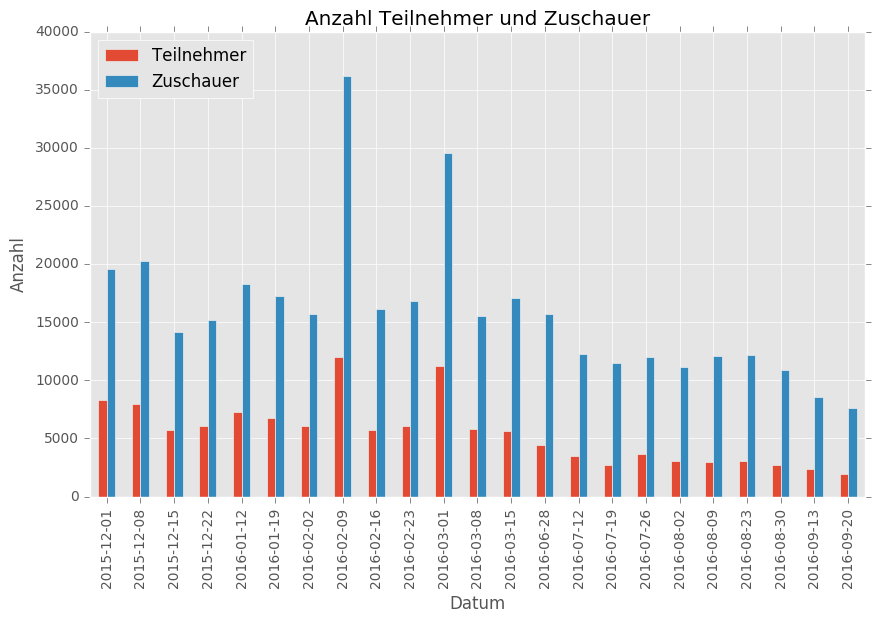

In [12]:
plot = joinedData[['participants', 'viewers']].plot(kind='bar', figsize=(10, 6), legend=False, title='Anzahl Teilnehmer und Zuschauer')
plot.set_xlabel('Datum')
plot.set_ylabel('Anzahl')

legend = plot.legend(loc=2)
legend.get_texts()[0].set_text('Teilnehmer')
legend.get_texts()[1].set_text('Zuschauer')

plot

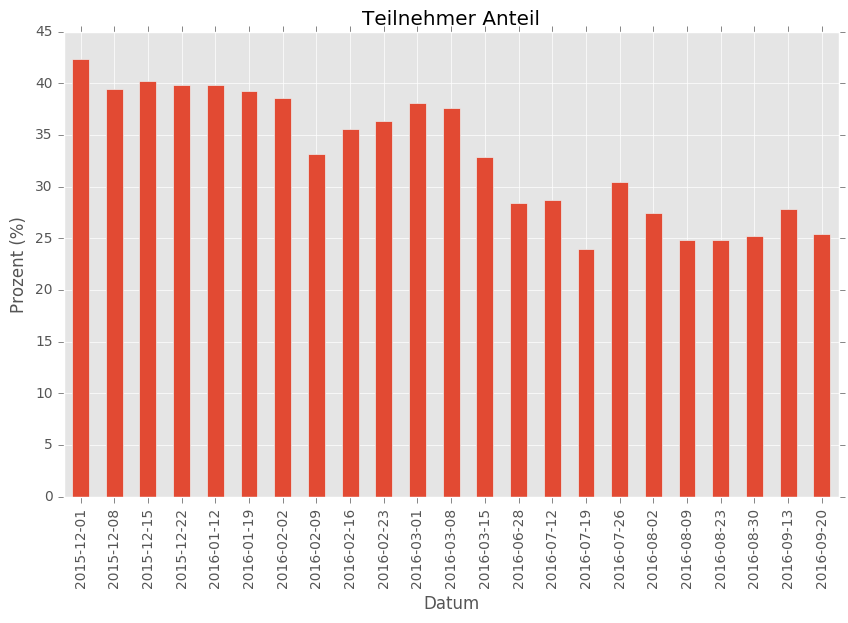

In [13]:
plot = joinedData['ratio'].plot(kind='bar', figsize=(10, 6), legend=False, title='Teilnehmer Anteil')
plot.set_xlabel('Datum')
plot.set_ylabel('Prozent (%)')

plt.ylim(ymin=0)

plot